In [1]:
import sys,os
import lowpass
import cv2
assert cv2.__version__[0] == '3', 'The fisheye module requires opencv version >= 3.0.0'
import numpy as np
import threading
import Queue
import time
from matplotlib import pyplot as plt
import math
import scipy

In [2]:

def homomorphic_filter(img):
    '''
    Code adapted from here :
    https://sites.google.com/site/bazeilst/tutorials#TUTO9
    As adapted from here :
    https://dsp.stackexchange.com/questions/42476/homomorphic-filter-python-overflow
    '''
    print('Entering homomorphic filter')
    start = time.time()
    sstart = time.time()
    rows,cols = img.shape
        
    rh, rl, cutoff = 2.5,0.5,32

    y  = img

    y_log = np.log(y+0.01)
    tconvert = time.time() - start
    print("time to compute first log %s", tconvert )


    start = time.time()
    y_fft = np.fft.fft2(y_log)
    tconvert = time.time() - start
    print("time to compute first fft %s", tconvert )

    start = time.time()
    y_fft_shift = np.fft.fftshift(y_fft)
    tconvert = time.time() - start
    print("time to compute second fft %s", tconvert )

    start = time.time()
    DX = cols/cutoff
    G = np.ones((rows,cols))
    for i in range(rows):
        for j in range(cols):
            G[i][j]=((rh-rl)*(1-np.exp(-((i-rows/2)**2+(j-cols/2)**2)/(2*DX**2))))+rl

    tconvert = time.time() - start
    print("time to compute for loop %s", tconvert )

    start = time.time()
    result_filter = G * y_fft_shift
    tconvert = time.time() - start
    print("time to compute result filter %s", tconvert )

    start = time.time()
    result_interm = np.real(np.fft.ifft2(np.fft.ifftshift(result_filter)))
    tconvert = time.time() - start
    print("time to compute third fft %s", tconvert )

    start = time.time()
    result = np.exp(result_interm)
    y = np.float32(result)


    tconvert = time.time() - start
    print("time to convert image back %s", tconvert )

    tconvert = time.time() - sstart
    print("time to DO ALL %s", tconvert )
    return y

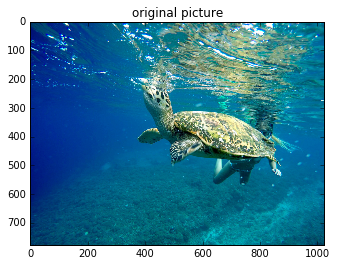

In [3]:
p = cv2.imread('tortu.jpg',3)
RGB_im = np.float32(cv2.cvtColor(p, cv2.COLOR_BGR2RGB))/255
plt.imshow(RGB_im)
plt.title('original picture')
plt.show()

In [4]:
img = np.float32(p)
img = img/255
        
img  = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)

y = img[:, :, 0]
u = img[:, :, 1]
v = img[:, :, 2]

In [5]:
rows,cols = y.shape
rh, rl, cutoff = 2.5,0.5,32
rows,cols

(777, 1024)

### Logarithm function

#### With numpy

In [6]:
%timeit y_log = np.log(y+0.01)

100 loops, best of 3: 9.16 ms per loop


#### With math

In [9]:
%%%timeit
y_log2 = []
for el in y:
    for pix in el:
        y_log2.append(math.log(pix+0.01))

1 loop, best of 3: 1.75 s per loop


#### With scipy

Requires square functions, we divide the img in squares

In [14]:
y_copy = y[:,0:777]
print y_copy.shape

(777, 777)


In [15]:
%timeit y_log3 = scipy.linalg.logm(y_copy)

logm result may be inaccurate, approximate err = 1.8158205895056455e-05
logm result may be inaccurate, approximate err = 1.8158205895056455e-05
logm result may be inaccurate, approximate err = 1.8158205895056455e-05
logm result may be inaccurate, approximate err = 1.8158205895056455e-05
1 loop, best of 3: 5.34 s per loop


#### Taylor approximation

In [16]:
print np.amax(y)

1.0


In [17]:
%%%timeit
x = y+0.01
log = (x-1) - (x-1)**2/2 + (x-1)**3/3

10 loops, best of 3: 61.5 ms per loop


lets check error!!

In [18]:
y_log = np.log(y+0.01)

x = y+0.01
log = (x-1) - (x-1)**2/2

print y_log[100][100]
print log[100][100]

A = log
B = y_log
mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

-1.5247364
-1.088335


0.110794276

#### Limit

In [19]:
def lnlm(x):
    n = 1000.0
    x = np.asarray(x)
    return n * ((x ** (1/n)) - 1)

In [20]:
print lnlm(0.5)
print lnlm(math.e)
a = [0.5, math.e, 1]
print lnlm(a)

-0.6929070095474943
1.0005001667083846
[-0.69290701  1.00050017  0.        ]


In [21]:
%%%timeit
n = 1000
limlog = n* ((y ** (1/n)) - 1)

1000 loops, best of 3: 1.04 ms per loop


In [22]:
y_log = np.log(y+0.01)

limlog = lnlm(y+0.01)

print y_log[100][100]
print limlog[100][100]

A = limlog
B = y_log
mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

-1.5247364
-1.5235543


8.277288e-07

### Fourier transform

Help with this in https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html
theory http://www.lip.uns.edu.ar/pdi/32.htm

#### Without DFT Optimization

##### Numpy

In [23]:
%%%timeit
f = np.fft.fft2(limlog)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

10 loops, best of 3: 107 ms per loop


In [24]:
f = np.fft.fft2(limlog)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

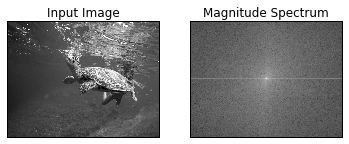

In [25]:
plt.subplot(121),plt.imshow(y, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

##### OpenCV

In [26]:
%%%timeit
dft = cv2.dft(np.float32(limlog),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

The slowest run took 17.11 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 15 ms per loop


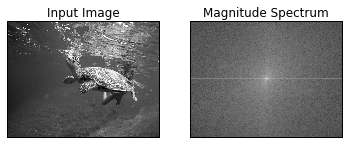

In [27]:
dft = cv2.dft(np.float32(limlog),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum2 = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
plt.subplot(121),plt.imshow(y, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum2, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

error

In [28]:
A = magnitude_spectrum
print A.shape
B = magnitude_spectrum2
print B.shape

print A[100][100]
print B[100][100]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

(777, 1024)
(777, 1024)
69.79341557111627
69.7934


2.0488935558458995e-08

#### With DFT optimization

Obtain optimal size of image

In [29]:
rows,cols = limlog.shape
print rows,cols

nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)
print nrows, ncols

nimg = np.zeros((nrows,ncols))
nimg[:rows,:cols] = limlog

777 1024
800 1024


##### Numpy

In [30]:
%%%timeit
rows,cols = limlog.shape

nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)

nimg = np.zeros((nrows,ncols))
nimg[:rows,:cols] = limlog

fft2 = np.fft.fft2(nimg)
fshift2 = np.fft.fftshift(fft2)
magnitude_spectrum4 = 20*np.log(np.abs(fshift2))

10 loops, best of 3: 80.8 ms per loop


In [31]:
fft2 = np.fft.fft2(nimg)
fshift2 = np.fft.fftshift(fft2)
magnitude_spectrum4 = 20*np.log(np.abs(fshift2))

##### OpenCV

In [32]:
%%%timeit
rows,cols = limlog.shape

nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)

nimg = np.zeros((nrows,ncols))
nimg[:rows,:cols] = limlog

dft2= cv2.dft(np.float32(nimg),flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift2 = np.fft.fftshift(dft2)
magnitude_spectrum3 = 20*np.log(cv2.magnitude(dft_shift2[:,:,0],dft_shift2[:,:,1]))

The slowest run took 5.01 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 23.2 ms per loop


In [33]:
dft2= cv2.dft(np.float32(nimg),flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift2 = np.fft.fftshift(dft2)
magnitude_spectrum3 = 20*np.log(cv2.magnitude(dft_shift2[:,:,0],dft_shift2[:,:,1]))

In [34]:
A = magnitude_spectrum4
print A.shape
B = magnitude_spectrum3
print B.shape

print A[100][100]
print B[100][100]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

(800, 1024)
(800, 1024)
52.0405533971772
52.040554


6.6492734928918525e-09

### High pass filter

#### Manually creating it

In [61]:
DX = ncols/cutoff
G = np.ones((nrows,ncols))

In [36]:
%%%timeit
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=((rh-rl)*(1-np.exp(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))))+rl

result_filter = G * fshift2

1 loop, best of 3: 1.96 s per loop


In [64]:
%%%timeit
G = np.ones((nrows,ncols))
G = G*(rh-rl)
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=1-np.e**(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
G = G +rl
result_filter = G * fshift2

1 loop, best of 3: 597 ms per loop


In [75]:
def exp_taylor(x):
    return 1+x+x**2/2+x**3/3+x**4/24+x**5/120+x**6/720+x**7/5040

print np.e**5
print exp_taylor(5)

148.413159103
147


In [102]:
def exp_lim(x):
    n = 10000
    return (1+x/n)**n

print np.e**5
print exp_lim(5.0)

148.413159103
148.227820292


In [97]:
%%%timeit
G = np.ones((nrows,ncols))
G = G*(rh-rl)
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=1-exp_taylor(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
G = G +rl
result_filter = G * fshift2

1 loop, best of 3: 1.04 s per loop


In [103]:
%%%timeit
G = np.ones((nrows,ncols))
G = G*(rh-rl)
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=1-exp_lim(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
G = G +rl
result_filter = G * fshift2

1 loop, best of 3: 579 ms per loop


In [110]:
%%%timeit
G = np.ones((nrows,ncols))
G = G*(rh-rl)

        
G = map(lambda x: x**2, G)

result_filter = G * fshift2

TypeError: can only concatenate list (not "float") to list

In [104]:
G = np.ones((nrows,ncols))
G = G*(rh-rl)
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=1-np.e**(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
G = G +rl

F = np.ones((nrows,ncols))
F = F*(rh-rl)
for i in range(nrows):
    for j in range(ncols):
        F[i][j]=1-exp_lim(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
F = F +rl



A = G
print A.shape
B = F
print B.shape

print A[700][200]
print B[700][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

(800, 1024)
(800, 1024)
1.5
1.5


0.0012292432724797183

In [108]:
print fshift2[700][200]
print G[700][200]
print F[700][200]
result_filter1 = np.float32(G) * fshift2

result_filter2 = np.float32(F) * fshift2

A = np.real(result_filter1)
print A.shape
B = np.real(result_filter2)
print B.shape

print A[700][200]
print B[700][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

(61.971017554681765+32.22567077008069j)
1.5
1.5
(800, 1024)
(800, 1024)
92.95652633202265
92.95652633202265


9205.915175285798

In [58]:
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=((rh-rl)*(1-np.exp(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))))+rl
result_filter = G * fshift2
result_filter

array([[-68.59302521 +0.j        ,  51.01015262+13.19473587j,
        -40.05902375-38.5173947j , ...,  21.28639587+17.95363639j,
        -40.05902375+38.5173947j ,  51.01015262-13.19473587j],
       [ 35.14014708+35.85806161j,   2.9664164  +6.8737862j ,
        -12.4248311  +0.60443799j, ..., -59.42979823-33.61975341j,
         21.20206542+16.16130813j, -37.68359609-41.80924298j],
       [-26.53234791-22.15072433j,  20.58667363-11.88052248j,
         26.59621883+20.92310931j, ...,  32.911955  +15.89435058j,
         -1.40880436 -8.43643619j,   1.22241685+42.61945815j],
       ...,
       [ 71.3959215 -42.2975523j ,  -1.18826557+20.18823539j,
         -2.2194326 +24.57944356j, ..., -22.86890099+39.45714671j,
         40.25469667+21.48319267j, -38.462948   +7.84010904j],
       [-26.53234791+22.15072433j,   1.22241685-42.61945815j,
         -1.40880436 +8.43643619j, ...,  12.29359714+22.91175733j,
         26.59621883-20.92310931j,  20.58667363+11.88052248j],
       [ 35.14014708-35.8580

#### Laplacian filtering

Why is laplacian Kernel a high pass filter?

The Laplacian kernel is like this:

In [38]:
laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])

Let's plot it:

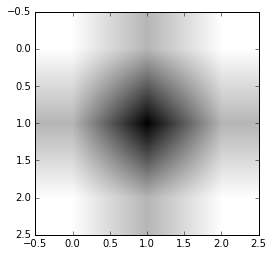

In [39]:
fft_filters = np.fft.fft2(laplacian) 
fft_shift = np.fft.fftshift(fft_filters)
mag_spectrum = np.log(np.abs(fft_shift)+1)

plt.imshow(mag_spectrum,cmap = 'gray')
plt.show()

From image, you can see what frequency region each kernel blocks(black), and what region it passes(white). 

#### Laplacian filtering with OpenCV function

In [40]:
%timeit laplacian = cv2.Laplacian(dft_shift2,cv2.CV_32F)

The slowest run took 157.56 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 1.89 ms per loop


In [59]:
print dft_shift2.shape
laplacian = cv2.Laplacian(dft_shift2,cv2.CV_32F)
print laplacian

(800, 1024, 2)
[[[  39.24074    178.66797  ]
  [ -31.019474  -122.704124 ]
  [  60.207787    83.073616 ]
  ...
  [ -56.565685   -91.98433  ]
  [ -46.795204   109.9749   ]
  [  18.477736  -143.81136  ]]

 [[ -60.731194   -91.90012  ]
  [   4.1119227   32.978218 ]
  [   4.105792     5.88414  ]
  ...
  [  93.54522    126.530716 ]
  [ -43.997654   -89.355255 ]
  [  91.59444     98.149086 ]]

 [[  57.197784   101.536476 ]
  [  18.131765   -47.11258  ]
  [ -55.745564   -18.269909 ]
  ...
  [ -59.213707  -114.9768   ]
  [  33.53672     23.500492 ]
  [ -99.73955    -18.632608 ]]

 ...

 [[ 122.085884  -154.13895  ]
  [ -61.130554    45.22107  ]
  [ -24.857735   -28.000055 ]
  ...
  [ -58.661045    26.94159  ]
  [ -14.088775   -85.44701  ]
  [   7.347141   120.35085  ]]

 [[-100.798004    86.045135 ]
  [ 105.225006   -28.6824   ]
  [ -33.53672     23.50049  ]
  ...
  [ -57.543922   -20.722115 ]
  [  55.745567   -18.269909 ]
  [ -35.36098    -25.860792 ]]

 [[ 108.53781   -107.59688  ]
  [-121.7

#### High pass filter

After applying the fftshift function we've got the lower frequencies in the center, so we can simply turn the first elements of the matrix to zero. In this with a window of 60x60

In [42]:
%%%timeit
crow,ccol = nrows/2 , ncols/2
dft_shift2_copy = dft_shift2.copy()
dft_shift2_copy[crow-30:crow+30, ccol-30:ccol+30,0] = 0
dft_shift2_copy[crow-30:crow+30, ccol-30:ccol+30,1] = 0

The slowest run took 4.82 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 692 µs per loop


In [43]:
crow,ccol = nrows/2 , ncols/2
dft_shift2_copy = dft_shift2.copy()
dft_shift2_copy[crow-30:crow+30, ccol-30:ccol+30,0] = 0
dft_shift2_copy[crow-30:crow+30, ccol-30:ccol+30,1] = 0

### Inverse Fourier Transform

#### Numpy

In [44]:
%timeit result_interm = np.real(np.fft.ifft2(np.fft.ifftshift(result_filter)))

10 loops, best of 3: 50.9 ms per loop


In [49]:
result_interm = np.real(np.fft.ifft2(np.fft.ifftshift(result_filter)))
result_interm

array([[-2.70487379, -2.4238771 , -2.06078619, ..., -1.09316228,
        -1.10594717, -1.08653526],
       [-2.37532343, -2.54155685, -2.45212905, ..., -0.99173791,
        -0.99987225, -0.97731529],
       [-2.03769383, -2.28595883, -2.51805467, ..., -0.90410855,
        -0.92010148, -0.89068752],
       ...,
       [ 1.60611579,  1.61234848,  1.61802147, ...,  1.58866048,
         1.59379689,  1.59976931],
       [ 1.72822149,  1.7381067 ,  1.74706987, ...,  1.69912912,
         1.70809522,  1.71800107],
       [ 1.86619513,  1.88031813,  1.89310044, ...,  1.82363353,
         1.83702669,  1.85148503]])

#### OpenCV

In [47]:
%%%timeit
f_ishift = np.fft.ifftshift(laplacian)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

100 loops, best of 3: 12 ms per loop


In [48]:
f_ishift = np.fft.ifftshift(laplacian)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
img_back

array([[ 561.5602 , 1820.0184 , 3383.6724 , ..., 1662.7742 , 1418.419  ,
        1265.6686 ],
       [ 357.64713, 1583.4612 , 3556.0667 , ...,  700.4584 ,  914.73126,
         351.22092],
       [1270.8639 ,  682.64734, 3616.0784 , ..., 1790.6423 ,  850.81854,
        1013.0698 ],
       ...,
       [ 657.196  , 1353.2108 , 3537.2935 , ..., 1077.422  ,  729.53296,
         439.9654 ],
       [ 657.84503, 1349.9761 , 3524.2966 , ..., 1075.2148 ,  728.92377,
         441.32944],
       [ 658.82513, 1345.2518 , 3511.2976 , ..., 1073.1171 ,  728.9271 ,
         442.45532]], dtype=float32)

#### OpenCV + Simply HPF

In [50]:
result_interm2 = np.real(np.fft.ifft2(np.fft.ifftshift(dft_shift2_copy)))
result_interm2

array([[[-1.34321444e+02, -1.36532625e+02],
        [ 9.41881678e+00,  7.24499268e+00],
        [ 9.06611116e+00,  7.00309528e+00],
        ...,
        [ 8.14498277e+00,  6.26248240e+00],
        [ 9.06611116e+00,  7.00309528e+00],
        [ 9.41881678e+00,  7.24499268e+00]],

       [[ 1.19436233e+01,  2.83850239e+01],
        [-8.57196254e-01,  7.20224111e-01],
        [-3.55730789e-01, -1.14859928e+00],
        ...,
        [ 2.38487707e-02, -3.03615120e+00],
        [-3.55730789e-01, -1.14859928e+00],
        [-8.57196254e-01,  7.20224111e-01]],

       [[ 1.52372363e+01, -4.55398952e+00],
        [-5.13087492e+00,  3.92258300e-02],
        [-3.34151197e+00,  2.21274495e-01],
        ...,
        [-1.38378288e+00,  1.83519295e-01],
        [-3.34151197e+00,  2.21274495e-01],
        [-5.13087492e+00,  3.92258300e-02]],

       ...,

       [[-1.88073008e+01,  1.07420044e+01],
        [-2.49556026e+00, -2.40425952e-01],
        [-7.38970578e-01, -7.53052194e-01],
        ...,
     

In [51]:
%%%timeit
f_ishift = np.fft.ifftshift(dft_shift2_copy)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

100 loops, best of 3: 13 ms per loop


In [52]:
f_ishift = np.fft.ifftshift(dft_shift2_copy)
img_back = cv2.idft(f_ishift)
img_back = img_back[:,:,0]
print img_back

[[-826770.   -730635.44 -608189.25 ... -318188.7  -314264.5  -301505.25]
 [-671215.3  -722811.7  -691064.5  ... -233765.62 -229447.86 -216893.8 ]
 [-514810.   -594593.8  -669358.9  ... -155294.2  -154805.84 -141361.12]
 ...
 [ 415745.6   423651.47  430403.22 ...  385054.53  396426.75  406668.28]
 [ 518466.2   527332.25  535025.56 ...  484612.72  497101.56  508392.38]
 [ 620001.4   629634.5   638088.44 ...  583612.    597003.06  609133.75]]


In [53]:
f_ishift = np.fft.ifftshift(dft_shift2_copy)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
img_back

array([[[134.32144393, 136.53262486],
        [127.44123497, 127.5325501 ],
        [112.24598308, 112.55720485],
        ...,
        [ 97.90498605,  98.43534544],
        [112.24598308, 112.55720485],
        [127.44123497, 127.5325501 ]],

       [[ 11.94362331,  28.3850239 ],
        [ 22.71233788,  11.98691296],
        [ 17.90519626,  10.90635927],
        ...,
        [ 13.19438701,  10.63428583],
        [ 17.90519626,  10.90635927],
        [ 22.71233788,  11.98691296]],

       [[ 15.23723626,   4.55398952],
        [  6.06459139,  19.04890423],
        [  4.18854492,  17.93272791],
        ...,
        [  2.3757866 ,  17.05875062],
        [  4.18854492,  17.93272791],
        [  6.06459139,  19.04890423]],

       ...,

       [[ 18.80730076,  10.74200439],
        [  9.39444941,  12.71563112],
        [  7.58964325,   9.76314632],
        ...,
        [  6.52040518,   7.47155218],
        [  7.58964325,   9.76314632],
        [  9.39444941,  12.71563112]],

       [[  3.86

### Reverse Logarithm Transform with exponential

In [54]:
%timeit result = np.exp(result_interm)

10 loops, best of 3: 71.6 ms per loop


In [55]:
result = np.exp(result_interm)

In [56]:
j = result[0:cols,0:rows]

In [57]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)

merged = cv2.merge((j,u,v))
imgf  = cv2.cvtColor(merged,cv2.COLOR_YUV2RGB)
res = np.hstack((RGB_im, imgf))
plt.imshow(res)
plt.title('homomorphic picture')
plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['log', 'f', 'fft2', 'magnitude_spectrum']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


error: /tmp/binarydeb/ros-kinetic-opencv3-3.3.1/modules/core/src/convert.cpp:337: error: (-215) mv[i].size == mv[0].size && mv[i].depth() == depth in function merge


#### OpenCV

In [ ]:
%timeit result2 = np.exp(img_back)

In [ ]:
result2 = np.exp(img_back)
print result2

In [ ]:
k = np.float32(result2)
k_original_size = k[0:rows,0:cols]
k_original_size

In [ ]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)

merged2 = cv2.merge((k_original_size,u,v))
imgf2  = cv2.cvtColor(merged2,cv2.COLOR_YUV2RGB)
res = np.hstack((RGB_im, imgf2))
plt.imshow(res)
plt.title('homomorphic picture')
plt.show()


%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)


plt.subplot(121),plt.imshow(RGB_im)
plt.title('Input Image')
plt.subplot(122),plt.imshow(k_original_size.shape, cmap = 'gray')
plt.title('Magnitude Spectrum')
plt.show()

#### Custom Simply HPF

In [ ]:
%timeit result2 = np.exp(img_back)

In [ ]:
result2 = np.exp(img_back)
k = np.float32(result2)
k_original_size = k[0:rows,0:cols]
k_original_size.shape

In [ ]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)

merged2 = cv2.merge((k_original_size,u,v))
imgf2  = cv2.cvtColor(merged2,cv2.COLOR_YUV2RGB)
res = np.hstack((RGB_im, imgf2))
plt.imshow(res)
plt.title('homomorphic picture')
plt.show()

In [ ]:
%%%timeit
otra = homomorphic_filter(y)

In [ ]:
otra = homomorphic_filter(y)
merged = cv2.merge((otra,u,v))
imgf2  = cv2.cvtColor(merged,cv2.COLOR_YUV2RGB)
res = np.hstack((RGB_im, imgf2))
plt.imshow(res)
plt.title('homomorphic picture')
plt.show()